In [2]:
import geopandas as gp
import numpy as pd
import xarray as xr
import regionmask
import rasterio
import rasterio.mask
import shapely
import fiona
import json
import glob

from numpy import asarray
from shapely.wkt import dumps, loads
from shapely.geometry import Polygon, mapping, shape

import matplotlib.pyplot as plt

In [3]:
collection = {"type":"FeatureCollection","features":[{"id":"49c0712bb6060d0b9b2ac383ab086d79","type":"Feature","properties":{},"geometry":{"coordinates":[[[143.04473876953125,-38.683365777523704],[143.2012939453125,-38.80332983969899],[143.30291748046875,-38.7926269578689],[143.3935546875,-38.80761054235758],[143.48419189453125,-38.88889501576177],[143.57208251953125,-38.88461920129189],[143.67095947265625,-38.79048618862272],[143.87969970703125,-38.706946051593846],[144.06646728515625,-38.50304202775689],[144.2889404296875,-38.438530965643],[144.31640625,-38.335193261052744],[144.21478271484375,-38.30286995515003],[144.07745361328125,-38.27915703945833],[143.90167236328125,-38.356734124667135],[143.0419921875,-38.36750215395045],[143.04473876953125,-38.683365777523704]]],"type":"Polygon"}}]}

In [4]:
selections = list()

for p in collection["features"]:
    if p["geometry"]["type"] is "Polygon":
        points = p["geometry"]["coordinates"]
        selections.append(Polygon(*points) )
        
selections

In [5]:
numbers = [0]
names = ['NSWVIC']
abbrevs = ['nswvic']

regionmask_obj = regionmask.Regions_cls('Mask', numbers, names, abbrevs, selections)

In [6]:
regionmask_obj

1 'Mask' Regions ()
nswvic

In [159]:
aus_region = regionmask.defined_regions.giorgi["AUS"]
print(aus_region)

Region: Australia (AUS / 1)
center: [132.5 -28. ]


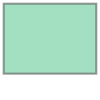

In [162]:
aus_poly = Polygon(aus_region.coords)
aus_poly

In [163]:
aus_bounds = list(aus_poly.bounds)
aus_bbox = list((aus_bounds[0], aus_bounds[2], aus_bounds[1], aus_bounds[3]))
aus_bbox

[110.0, 155.0, -45.0, -11.0]

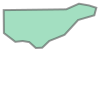

In [164]:
query_poly = selections[0]
query_poly

In [165]:
query_bounds = list(query_poly.bounds)
query_bbox = list((query_bounds[0], query_bounds[2], query_bounds[1], query_bounds[3]))
query_bbox

[143.0419921875, 144.31640625, -38.88889501576177, -38.27915703945833]

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/anaconda3/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


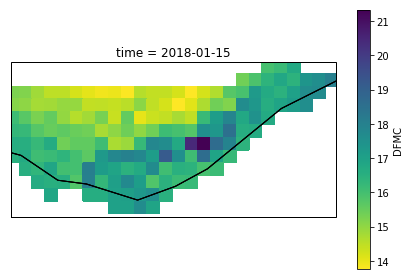

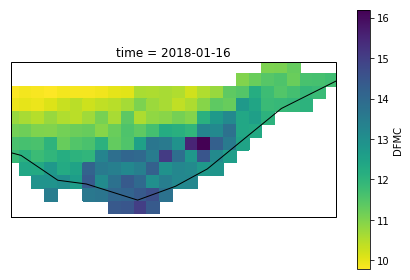

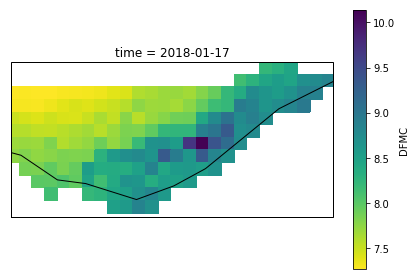

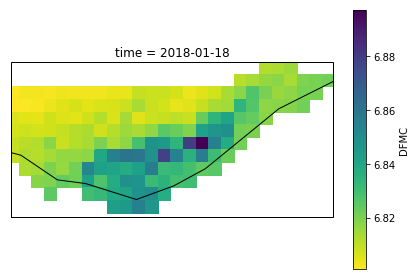

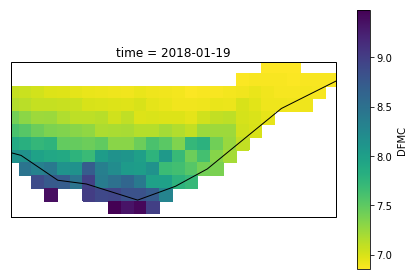

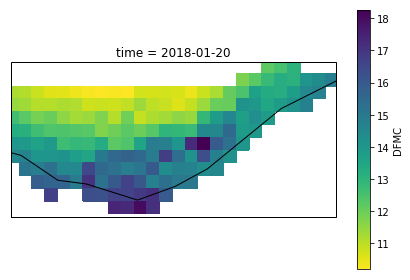

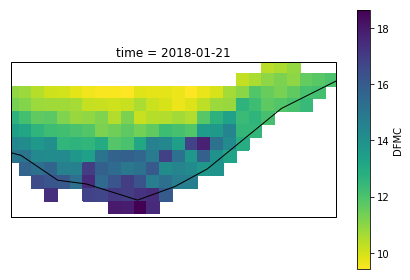

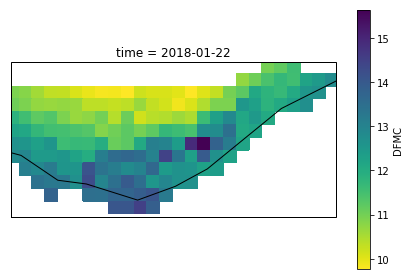

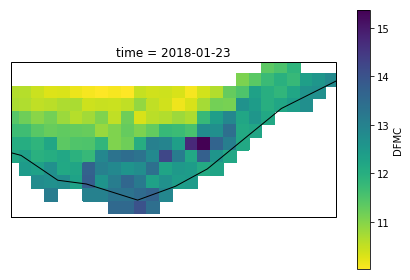

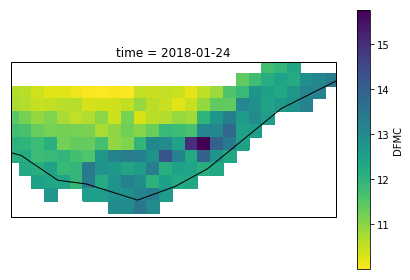

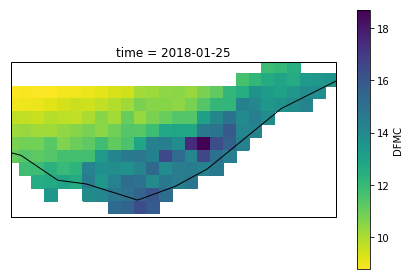

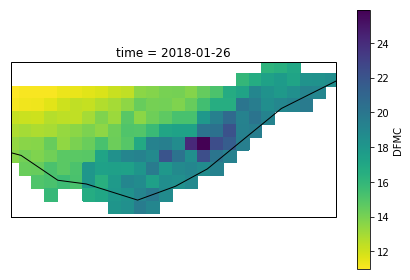

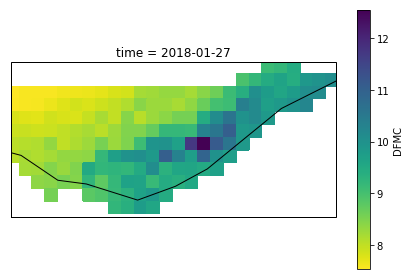

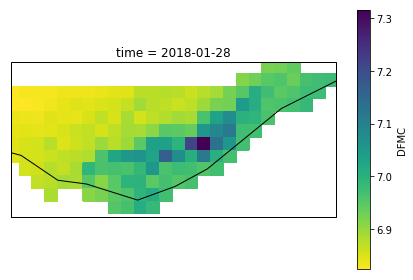

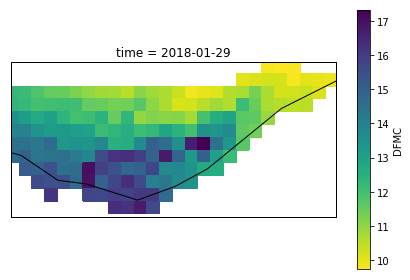

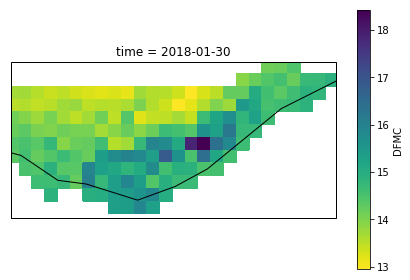

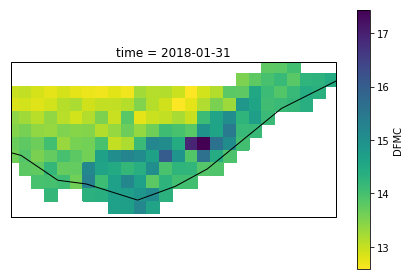

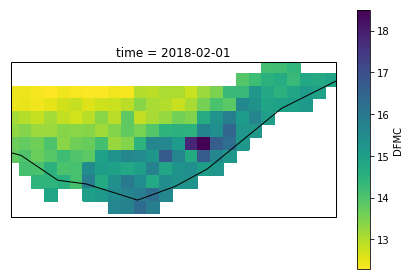

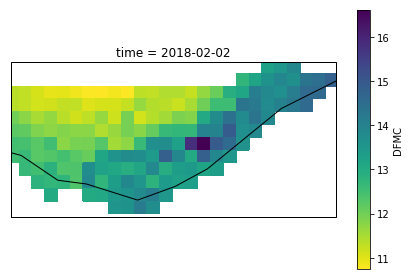

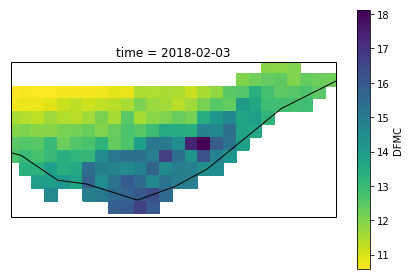

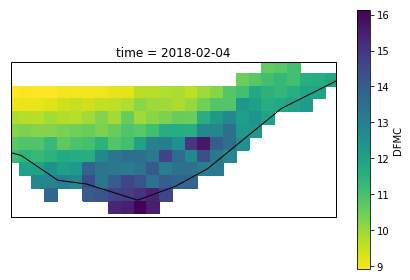

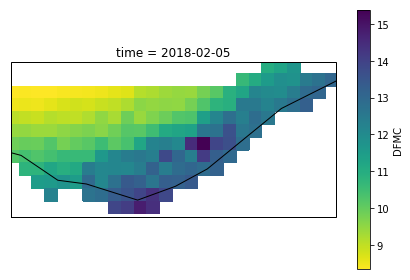

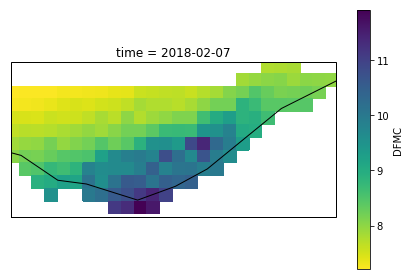

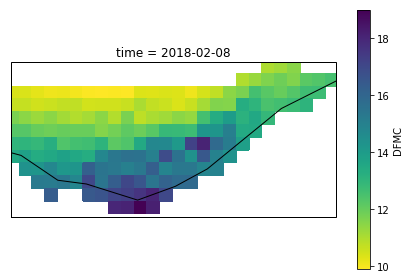

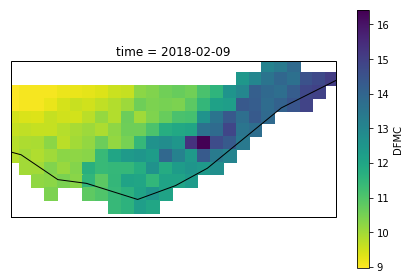

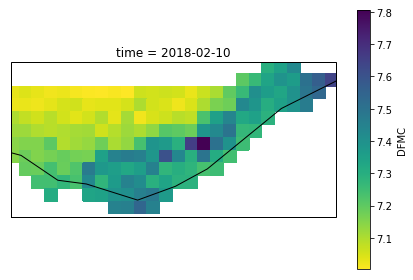

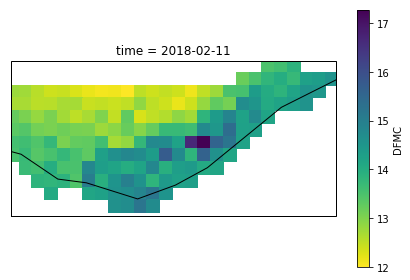

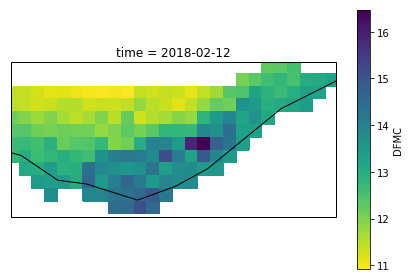

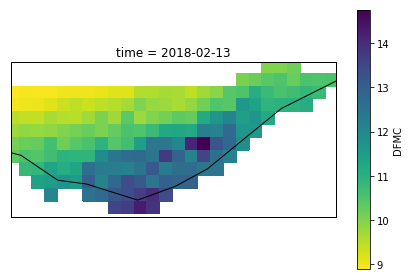

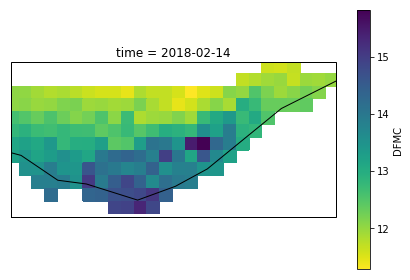

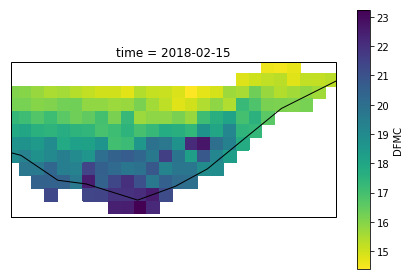

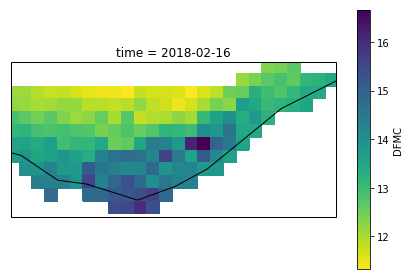

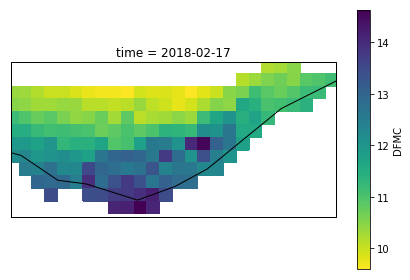

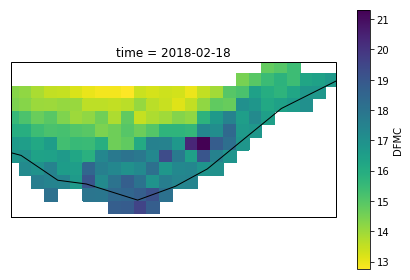

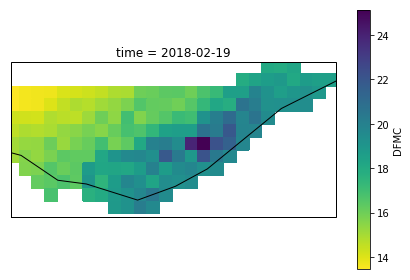

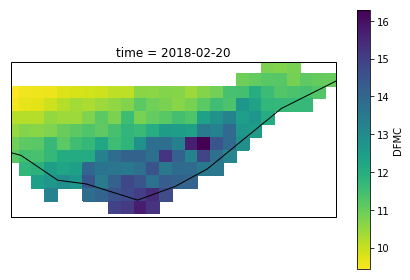

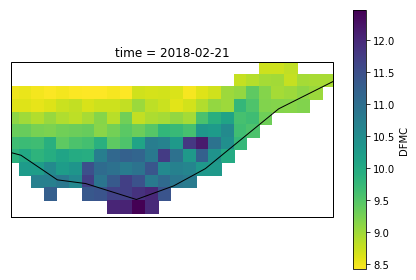

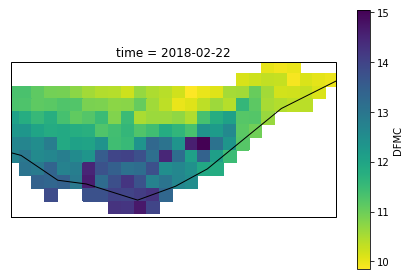

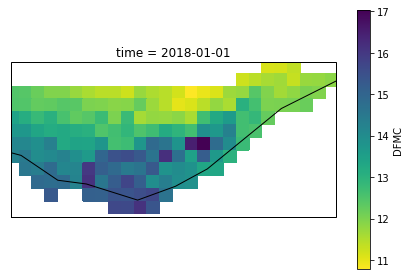

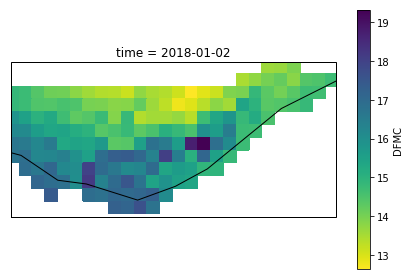

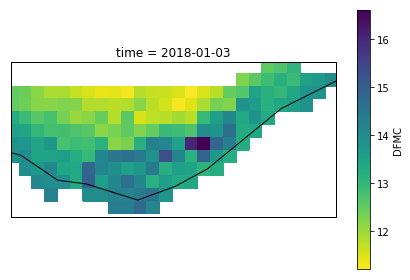

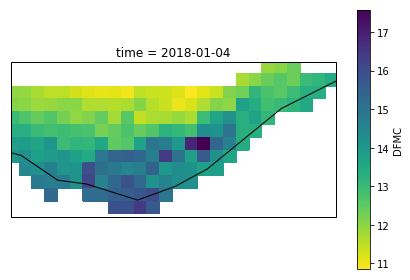

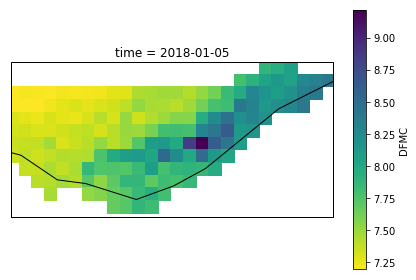

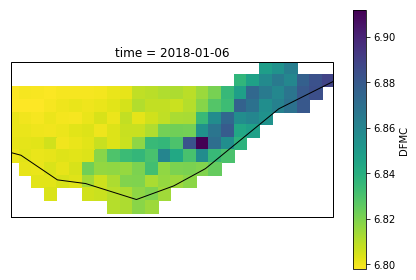

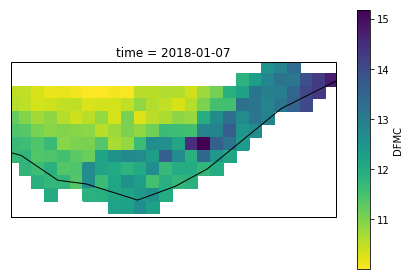

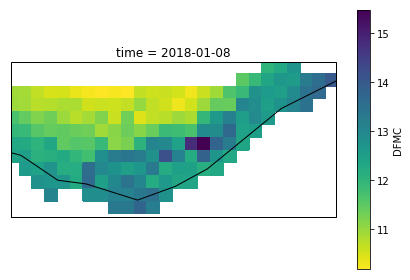

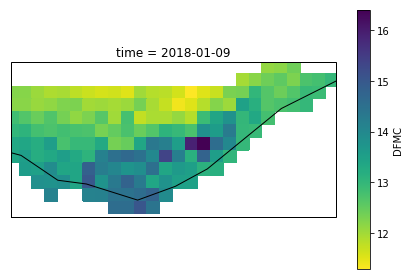

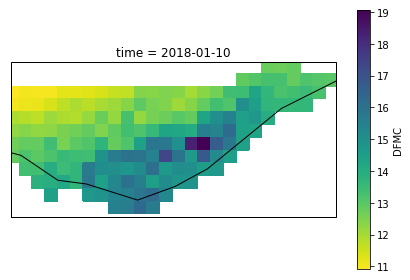

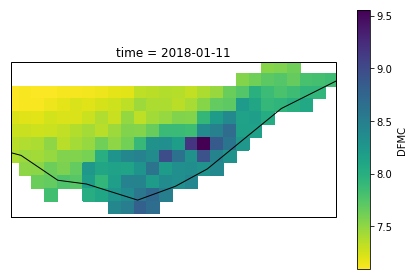

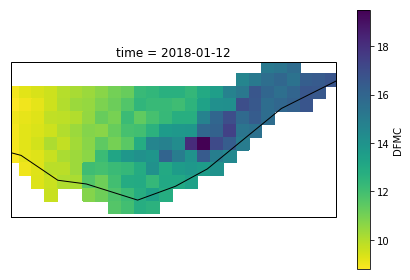

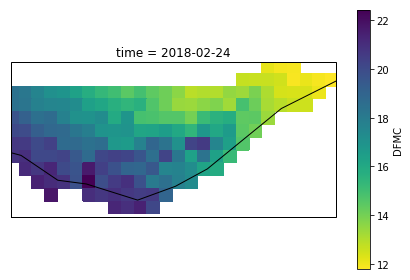

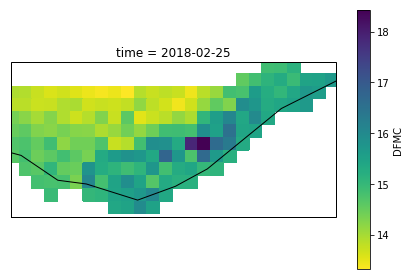

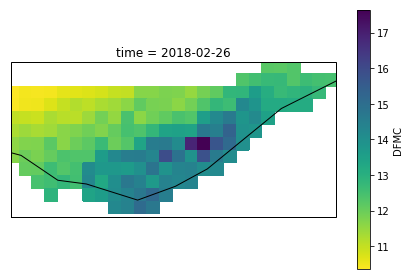

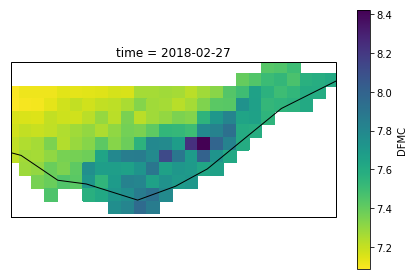

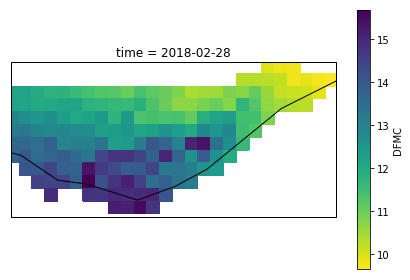

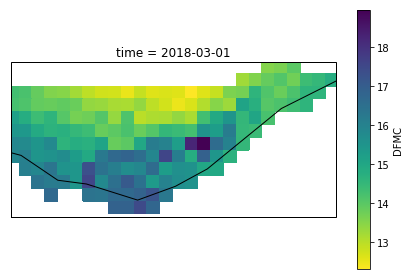

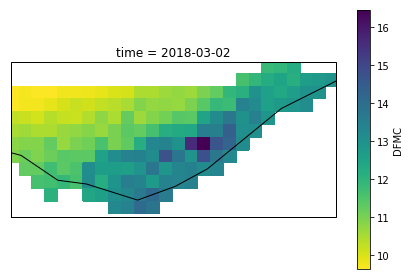

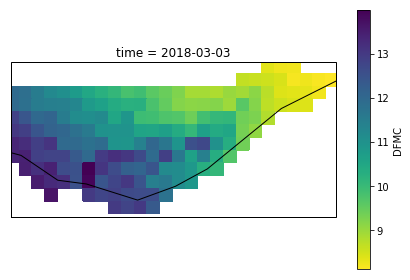

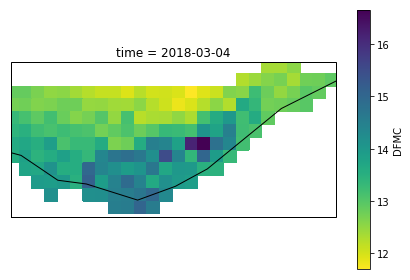

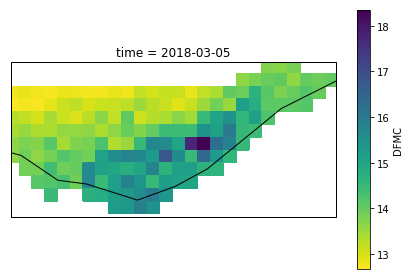

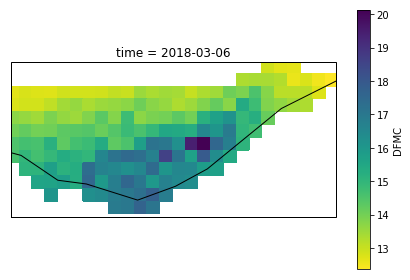

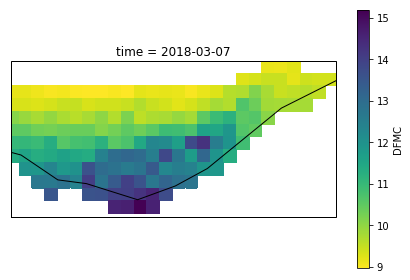

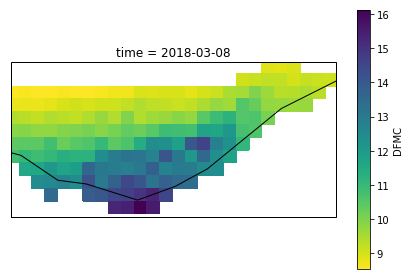

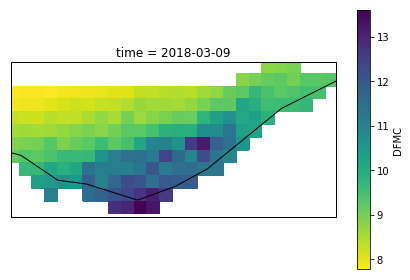

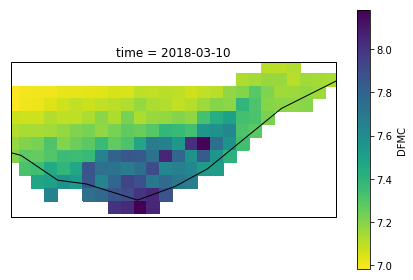

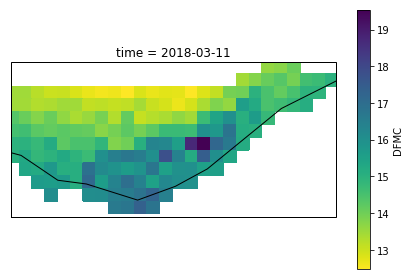

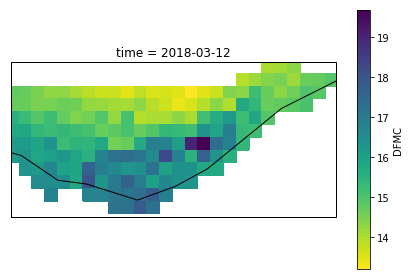

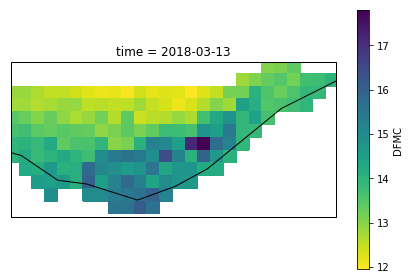

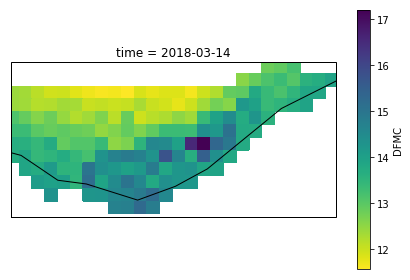

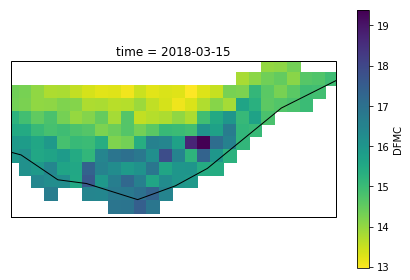

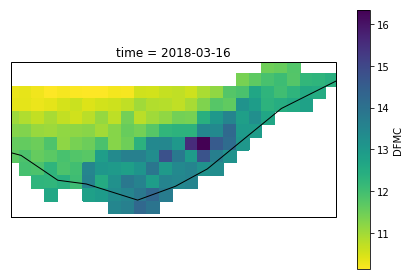

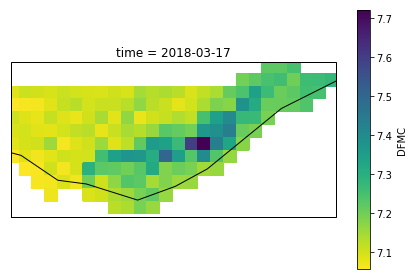

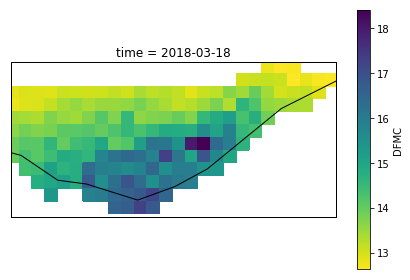

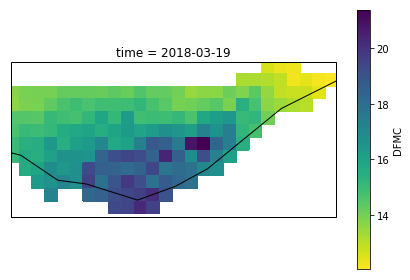

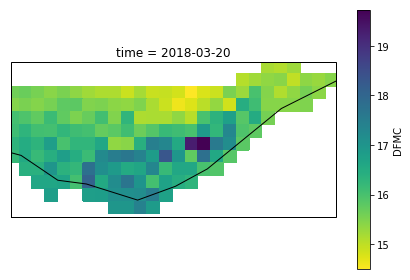

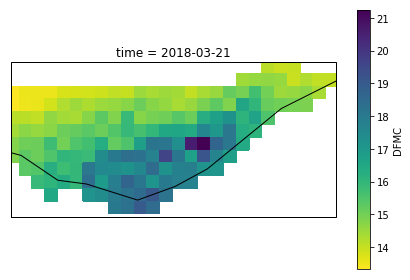

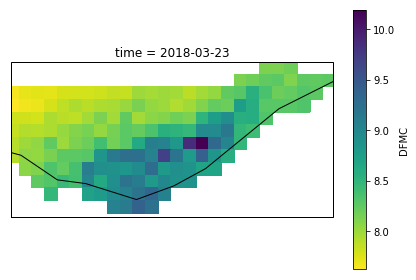

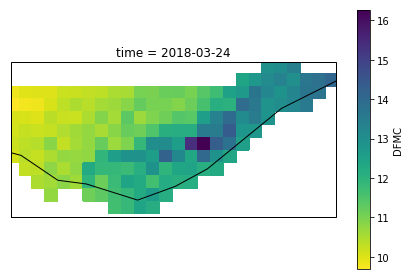

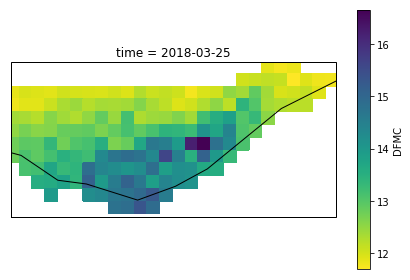

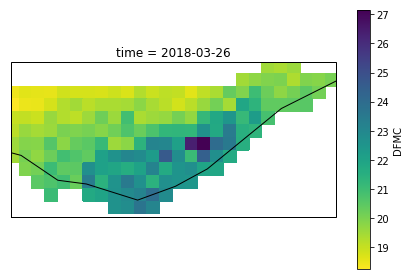

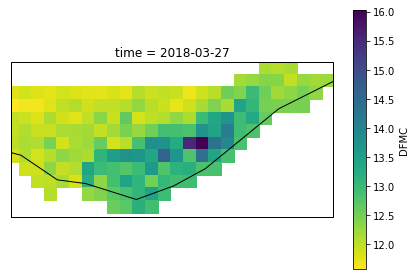

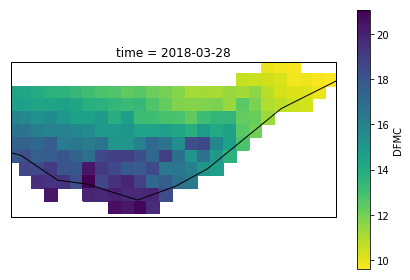

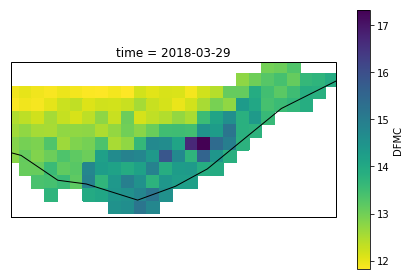

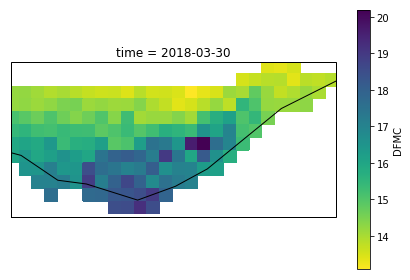

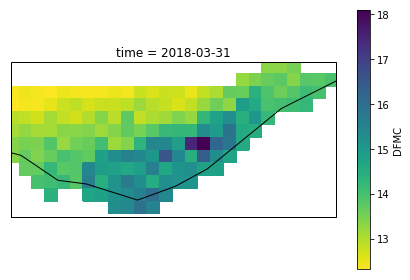

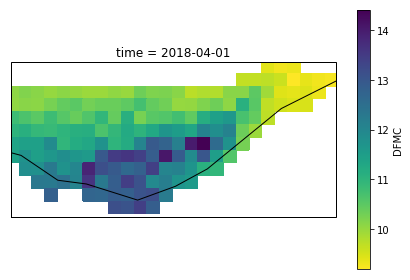

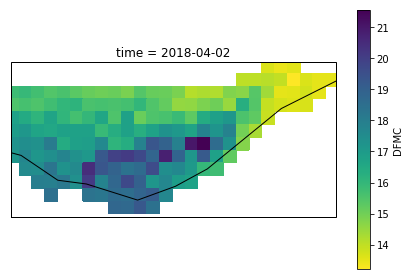

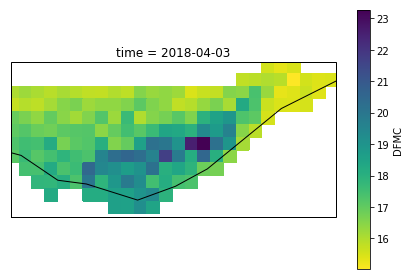

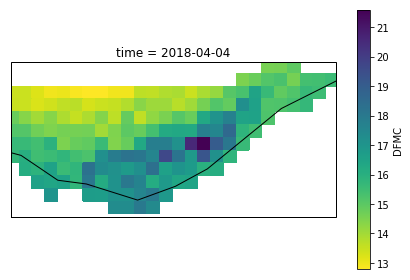

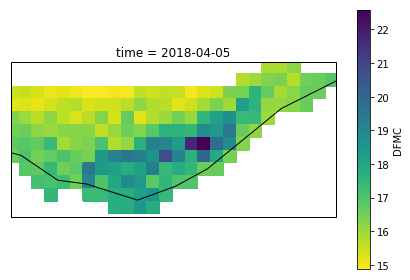

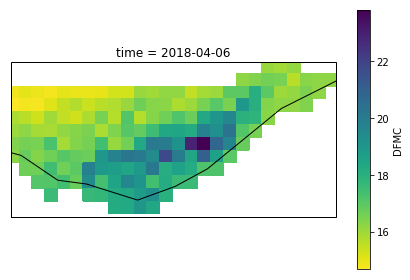

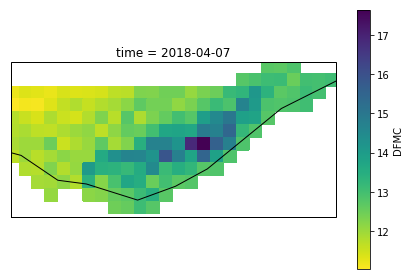

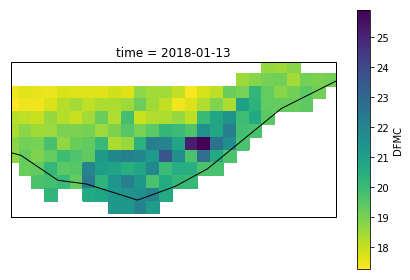

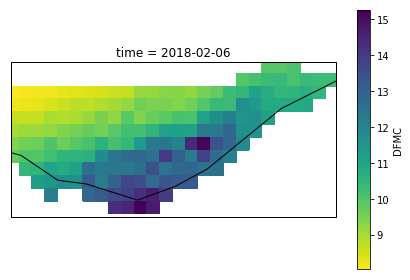

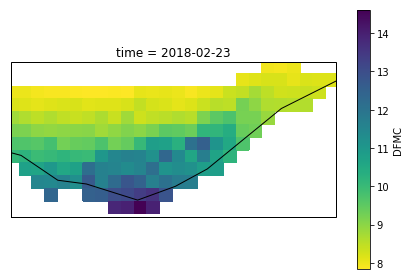

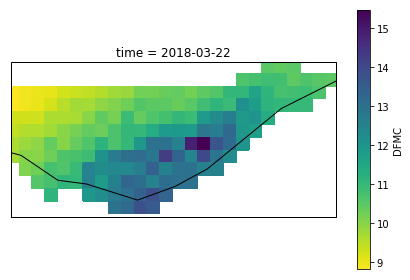

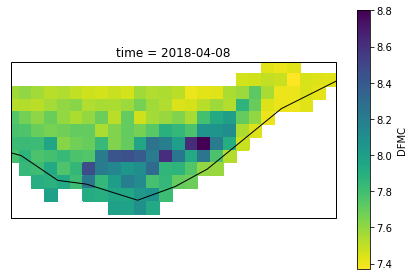

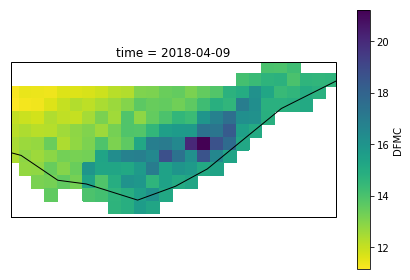

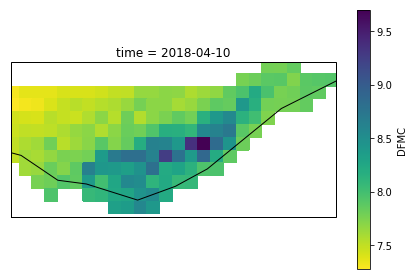

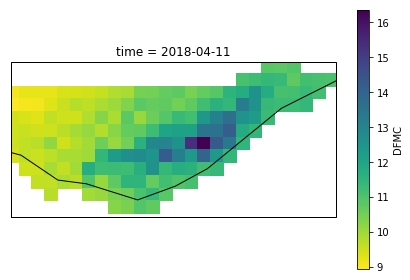

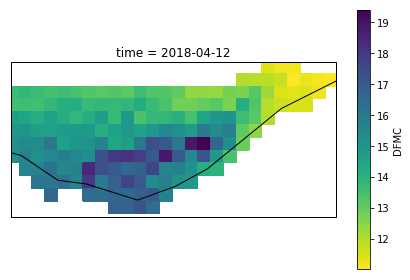

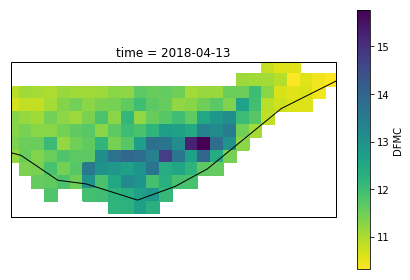

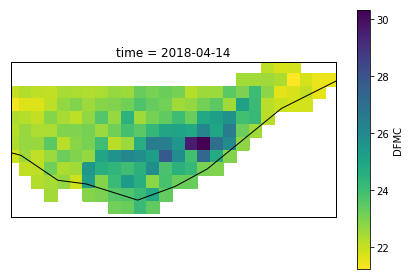

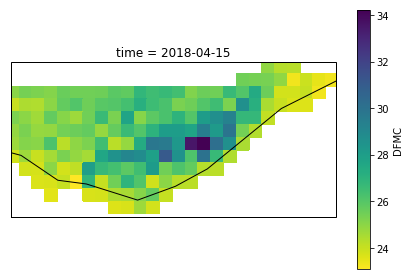

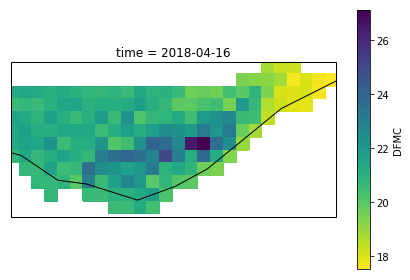

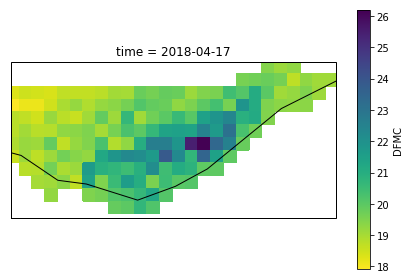

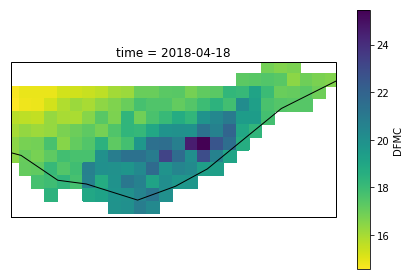

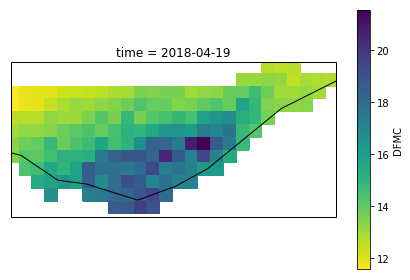

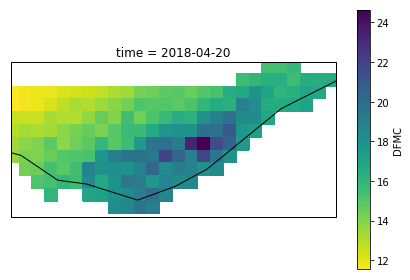

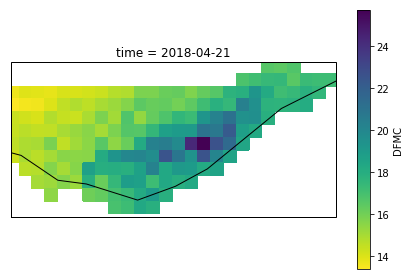

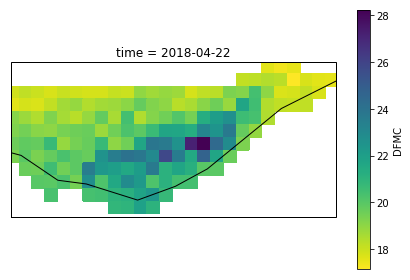

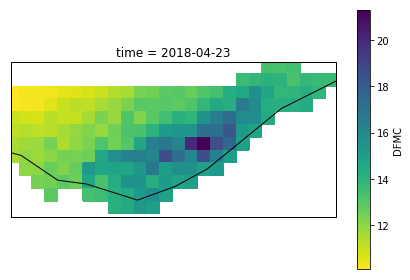

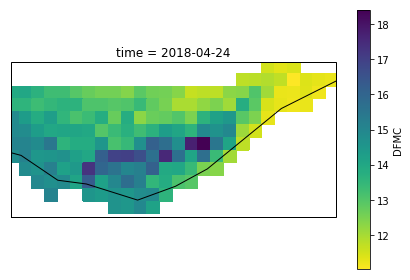

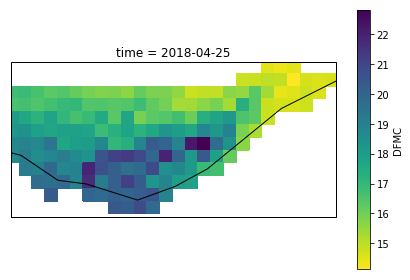

In [170]:
import cartopy.crs as ccrs
import numpy as np
from rasterstats import zonal_stats

with xr.open_mfdataset(glob.glob('/media/arawlins/Backups/DataSources/geoserver_data/FuelModels/Dead_FM/DFMC/DFMC_2018*.nc')) as twenty_eighteen:
    ds = twenty_eighteen.squeeze("observations")
    da = ds["DFMC"]
    for t in range(1, len(da["time"])):
        
#         ax = regionmask_obj.plot()
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent(query_bbox, crs=ccrs.PlateCarree())
        ax.coastlines(resolution='50m')
        plt.ylabel('latitude')
        plt.xlabel('longitude')
        
        fuel_moistures = da.isel(time=t)
        
        mask = regionmask_obj.mask(fuel_moistures['longitude'], fuel_moistures['latitude'], xarray=True)
        masked_area = np.ma.masked_invalid(mask)

        masked_fuel_moistures = fuel_moistures.where(masked_area == 0)
        
        
#         ds_affine = ds.affine
#         print(zonal_stats(query_poly, array=fuel_moistures, affine=ds_affine, stats="count min mean max median"))
        
        masked_fuel_moistures.plot(cmap='viridis_r')
        plt.tight_layout()
        plt.show()


In [14]:
def apply_mask_to(src: xr.DataArray) -> xr.DataArray:
    dest = rasterio.mask.mask(src, self.mask_shape, crop=True)